# 音楽ジャンル分類（music2vec）

    [参考サイト]
    https://qiita.com/KMASAHIRO/items/cae4dfb0657eec4a2dca


# 作曲家の指定

In [ ]:
composer1 = '_alanmenken'
composer2 = '_mozart'

# データの用意

### インポート



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install wget
! pip install pydot
! pip install pydotplus

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=fdfb12710591d041c6637d2012a4c92ef6c031040a1dcd598d03f3c6897951dc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.manifold import TSNE
import wget
import shutil
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import librosa
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

<ipython-input-5-4697d8d1d796>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  ms.use('seaborn-muted')


### データの前処理

In [ ]:
# ドライブ上のフォルダを指定
drive_folder_path = '/content/drive/MyDrive/卒業論文/GTZAN'

# Colabにフォルダをコピー
colab_folder_path = '/content/genres'
shutil.copytree(drive_folder_path, colab_folder_path)

# コピーされたフォルダ内のファイル/フォルダを確認
os.listdir(colab_folder_path)

['_mozart',
 '_alanmenken',
 'rock',
 'country',
 'classical',
 'blues',
 'jazz',
 'reggae',
 'hiphop',
 'metal',
 'disco',
 'pop']

In [ ]:
# SoundNetの事前学習済み重みをgithub上から持ってくる
# クローンの作成
! git clone https://github.com/KMASAHIRO/music2vec

Cloning into 'music2vec'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 67 (delta 3), reused 4 (delta 1), pack-reused 56
Receiving objects: 100% (67/67), 154.06 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (12/12), done.


In [ ]:
# ロードする音楽ファイル名の作成
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock",composer1,composer2]
gtzan_filenames = list()

for genre in genre_list:
    if genre == composer1 or genre == composer2:
        for i in range(50):
            gtzan_filenames.append("/content/genres/" + genre + "/" + genre + ".000{:02}.wav".format(i))
    else:
        for i in range(100):
            gtzan_filenames.append("/content/genres/" + genre + "/" + genre + ".000{:02}.wav".format(i))

gtzan_filenames = np.asarray(gtzan_filenames)

In [ ]:
gtzan_filenames

array(['/content/genres/blues/blues.00000.wav',
       '/content/genres/blues/blues.00001.wav',
       '/content/genres/blues/blues.00002.wav', ...,
       '/content/genres/_mozart/_mozart.00047.wav',
       '/content/genres/_mozart/_mozart.00048.wav',
       '/content/genres/_mozart/_mozart.00049.wav'], dtype='<U49')

In [ ]:
# ラベルの作成
gtzan_labels = list()

# データセット10ジャンル分を生成
for i in range(10):
  for k in range(100):
    gtzan_labels.append(tf.one_hot(i,12))

# アランメンケン50曲分を生成
for j in range(50):
    gtzan_labels.append(tf.one_hot(10,12))

# モーツァルト50曲分を生成
for j in range(50):
    gtzan_labels.append(tf.one_hot(11,12))

gtzan_labels = np.asarray(gtzan_labels)

In [ ]:
# データをシャッフル(最初はジャンルごとにソートされている)
np_random = np.random.RandomState(seed=1)
new_gtzan_filenames = np_random.permutation(gtzan_filenames)
np_random = np.random.RandomState(seed=1)
new_gtzan_labels = np_random.permutation(gtzan_labels)

In [ ]:
# DANetのテストデータと同じテストデータを使用する
# 後でDANetの出力を分類させるタスクを行うため
with open("/content/music2vec/test_data.txt","rb") as f:
  data_dict = pickle.load(f)

lacia_test_filenames = data_dict['gtzan_filenames']
test_labels = data_dict['gtzan_labels']

In [ ]:
# テストラベルの長さ修正
_test_labels = test_labels.copy()
t_t = list()
list_t_l = _test_labels.tolist()

for t in list_t_l:
    t.append(0)
    t.append(0)
    t_t.append(t)

ttt = np.array(t_t)
t_l = ttt.astype(np.float32)
test_labels = t_l.copy()
#test_labels = t_l

In [ ]:
# DANet訓練時とデータの配置場所が異なるので、ファイルのパスを変更する
test_filenames = list()
for file in lacia_test_filenames:
  splitted = file.split('/')[2:]
  test_filenames.append('/content/'+'/'.join(splitted))
test_filenames = np.asarray(test_filenames)

In [ ]:
# 先に用意していた音楽ファイルの内、テストデータとなるものを抽出
# argmax：配列で一番大きい要素のインデックス（順番）を返す関数

duplicated_index = list()
for file in test_filenames:
  index = np.argmax(new_gtzan_filenames==file)
  duplicated_index.append(index)

In [ ]:
# テストデータを用意していた音楽ファイルから取り除き、訓練データとして使用する
train_filenames = np.delete(new_gtzan_filenames,duplicated_index,axis=0)
train_labels = np.delete(new_gtzan_labels,duplicated_index,axis=0)

Pythonにはイテレータとジェネレータという概念があります。

★イテレータ

反復して要素を取り出すことが出来る型のこと。Pythonのリストやセット、辞書型はイテレーションすることが出来るので、これらのオブジェクトはイテレータである。

★ジェネレータ

イテレータの一種。要素を取り出すごとに処理を実行して、要素を生成することが出来る。ジェネレータはyieldを使って作る。

★yieldを使うメリット

return文でそのまま値を返す関数では、一度に大きなリストが返ってくるような関数だと、たくさんのメモリを一度に消費してしまう。
yieldを使う事でその莫大な量の戻り値を小分けにして返すことが出来る。これによって関数の実行をその都度中断し、少量ずつデータを返す事でメモリの消費量を抑えることが出来る。

In [ ]:
## ジェネレータ関数

# 音楽データは特定の形状に変換
# 与えられたファイル名とラベルから音楽データのバッチを生成
# バッチが終了した場合データをシャッフルし新しいバッチを生成する

def generator(filenames, labels, batch_size):
  # インデックスの初期化
  index = 0
  # 乱数のシード
  seed_num = 0
  # ファイルとラベルのコピー
  # copy()を使用しないとnew_filenamesだけでなくfilenamesにも影響が出る
  new_filenames = filenames.copy()
  new_labels = labels.copy()

  while True:
    # 学習データのリスト
    train_inputs = list()
    # 学習ラベルのリスト
    train_labels = list()

    # バッチサイズが残りのデータ数を超える場合シャッフルしてindexをリセット
    if index+batch_size>len(filenames):
      index = 0
      np_random = np.random.RandomState(seed=seed_num)
      new_filenames = np_random.permutation(new_filenames)
      np_random = np.random.RandomState(seed=seed_num)
      new_labels = np_random.permutation(new_labels)
      seed_num += 1

    # バッチサイズ分のデータを生成
    for i in range(batch_size):
      # librosaを使用して音楽データを読み込み
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      # 長さ調節
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      # スケーリング
      y *= 256.0
      # データの形状を変更
      y = np.reshape(y,(-1,1))
      # 学習データに追加
      train_inputs.append(y)
      # 学習ラベルに追加
      train_labels.append(new_labels[index])
      index += 1

    # 学習データと学習ラベルをNumPy配列に変換
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [ ]:
# 訓練データをsoundnetに入力して出力を平坦化したものをpca分析するときに使うジェネレータ
def pca_generator(filenames, labels, batch_size):
  index = 0
  seed_num = 0
  new_filenames = filenames.copy()
  new_labels = labels.copy()
  while True:
    train_inputs = list()
    train_labels = list()
    if index+batch_size>len(filenames):
      batch_size = len(filenames) - index

    for i in range(batch_size):
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      y *= 256.0
      y = np.reshape(y,(-1,1))
      train_inputs.append(y)
      train_labels.append(new_labels[index])
      index += 1
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [ ]:
# 中身の確認
y,sr = librosa.load(test_filenames[0],sr=22050,mono=True,dtype=np.float32)
print(len(y))
print(np.zeros(675808-len(y)))
print(len(np.zeros(675808-len(y))))
y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
print(len(y))
print(type(y))

661794
[0. 0. 0. ... 0. 0. 0.]
14014
675808
<class 'numpy.ndarray'>


In [ ]:
# テストデータは量が少なくメモリが十分なので先にロードしておく
test_inputs = list()
for file in test_filenames:
  y,sr = librosa.load(file,sr=22050,mono=True,dtype=np.float32)
  y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
  y *= 256.0
  y = np.reshape(y,(-1,1))
  test_inputs.append(y)
test_inputs = np.asarray(test_inputs)

In [ ]:
test_inputs.shape

(50, 675808, 1)

In [ ]:
# 確認
print("[データ総数]")
print("ファイル数："+str(len(new_gtzan_filenames)))
print("ラベル数　："+str(len(new_gtzan_labels)))
print("[テストデータ]")
print("ファイル数："+str(len(test_filenames)))
print("ラベル数　："+str(len(test_labels)))
print("[トレーニングデータ]")
print("ファイル数："+str(len(train_filenames)))
print("ラベル数　："+str(len(train_labels)))
print("[ジャンル＆作曲家]")
print(len(test_labels[0]))
print(len(train_labels[0]))

[データ総数]
ファイル数：1100
ラベル数　：1100
[テストデータ]
ファイル数：50
ラベル数　：50
[トレーニングデータ]
ファイル数：1050
ラベル数　：1050
[ジャンル＆作曲家]
12
12


### モデルの構築と学習


- 事前学習済みの重みを用いてSoundNetを構築する関数(https://github.com/pseeth/soundnet_keras/blob/master/soundnet.py より)

In [ ]:
# 以下修正あり
#from keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
#from tensorflow.python.keras import layers
#from tensorflow.python.keras.models import Sequential
#import numpy as np
#import librosa

In [ ]:
model_weights = np.load('/content/music2vec/music2vec/sound8.npy',allow_pickle=True,encoding='bytes').item()

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from tensorflow.keras.models import Sequential
import numpy as np
import librosa

def build_model():
    """
    Builds up the SoundNet model and loads the weights from a given model file
    SoundNetモデルを構築し、指定されたモデルファイルから重みをロードします
    (8-layer model is kept at models/sound8.npy).
    :return:
    """

    # 重みmodel_weightsのDL
    model_weights = np.load('/content/music2vec/music2vec/sound8.npy',allow_pickle=True,encoding='bytes').item()

    # 辞書型｛key：value｝→全てのkeyを取得する
    keys = list()
    for key in model_weights.keys():
      keys.append(key)
    # バイト文字列からUnicodeに変換→dict.pop(key)で特定のkeyの要素を消去
    for name in keys:
      model_weights[name.decode('utf-8')] = model_weights[name]
      # model_weightsから'conv3','conv2'など先頭の要素が無くなる
      model_weights.pop(name)
      ch_keys = list()
      # ch_keys→[b'weights', b'biases']
      for key in model_weights[name.decode('utf-8')]:
        ch_keys.append(key)
      # model_weightsから'weights','biases'など先頭の要素が無くなる
      for ch_name in ch_keys:
        model_weights[name.decode('utf-8')][ch_name.decode('utf-8')] = model_weights[name.decode('utf-8')][ch_name]
        model_weights[name.decode('utf-8')].pop(ch_name)

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None, None, 1)))
    # (batch_input_shape=(None, None, 1)→3番目はデータのチャネル数（1次元：波形）

    # filter_parametersリストはCNNのアーキテクチャを設定するパラメータのリスト
    # 各要素は1つの畳み込み層に関する情報を含む
    """
    'name':畳み込み層の名前や識別子
    'num_filters': 畳み込み層が持つフィルタ（カーネル）の数
    'padding': ゼロパディングの量（演算後の出力のサイズを制御する）
    'kernel_size': 畳み込み操作に使用されるカーネル（フィルタ）のサイズ
    'conv_strides': カーネルを入力データ上でスライドさせるスライド幅
    'pool_size': プーリング層のプーリングウィンドウ（領域）のサイズ
    'pool_strides': プーリング操作のスライド幅
    """

    filter_parameters = [{'name': 'conv1', 'num_filters': 16, 'padding': 32,
                          'kernel_size': 64, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv2', 'num_filters': 32, 'padding': 16,
                          'kernel_size': 32, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv3', 'num_filters': 64, 'padding': 8,
                          'kernel_size': 16, 'conv_strides': 2},

                         {'name': 'conv4', 'num_filters': 128, 'padding': 4,
                          'kernel_size': 8, 'conv_strides': 2},

                         {'name': 'conv5', 'num_filters': 256, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2,
                          'pool_size': 4, 'pool_strides': 4},

                         {'name': 'conv6', 'num_filters': 512, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv7', 'num_filters': 1024, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv8_2', 'num_filters': 401, 'padding': 0,
                          'kernel_size': 8, 'conv_strides': 2},
                         ]

    for x in filter_parameters:
        model.add(ZeroPadding1D(padding=x['padding']))
        model.add(Conv1D(x['num_filters'],
                         kernel_size=x['kernel_size'],
                         strides=x['conv_strides'],
                         padding='valid'))
        weights = model_weights[x['name']]['weights'].reshape(model.layers[-1].get_weights()[0].shape)
        biases = model_weights[x['name']]['biases']

        model.layers[-1].set_weights([weights, biases])

        if 'conv8' not in x['name']:
            gamma = model_weights[x['name']]['gamma']
            beta = model_weights[x['name']]['beta']
            mean = model_weights[x['name']]['mean']
            var = model_weights[x['name']]['var']


            model.add(BatchNormalization())
            model.layers[-1].set_weights([gamma, beta, mean, var])
            model.add(Activation('relu'))
        if 'pool_size' in x:
            model.add(MaxPooling1D(pool_size=x['pool_size'],
                                   strides=x['pool_strides'],
                                   padding='valid'))

    return model

- モデル構築

In [ ]:
soundnet = build_model()

In [ ]:
# 入力層の定義
music2vec_input = tf.keras.Input(shape=(675808,1))
# 入力層の追加
x = soundnet(music2vec_input)
# LSTMなど追加（任意の層を前の層 x に接続する）
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(100)(x)
# 出力層の定義（10ジャンル→12ジャンルに変更）
music2vec_output = tf.keras.layers.Dense(12,activation='softmax')(x)
# モデルの定義（モデル全体を変数 music2vec で表す）
music2vec = tf.keras.Model(inputs=music2vec_input,outputs=music2vec_output)

### ↑このようにモデルを定義すると後でモデルをコンパイルして訓練し予測を行う際に music2vec を使用できます。

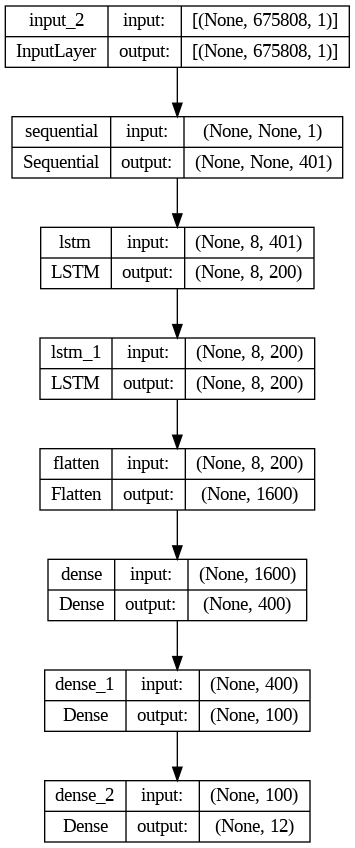

In [ ]:
# モデル可視化(Music2Vec)
from tensorflow.keras.utils import plot_model
plot_model(music2vec, show_shapes=True)
#music2vec.summary()

# 学習

In [ ]:
music2vec.compile(optimizer='rmsprop',loss='CategoricalCrossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 25
steps = len(train_filenames)//batch_size

**😊コード解説**（訓練データでモデルを学習させる）

    model-name.fit(train_data, train_labels,batch_size=1024, epochs=20,verbose=1, validation_data=(x_test, y_test))

・train_data, train_labels：訓練データを使用。

・batch_size：バッチサイズは機械学習分野の慣習として「2のn乗」（32, 64, 128, 256, 512, 1024, 2048）が使われることが多い。学習する際の異常値の影響を小さくするため、バッチサイズのようにサブセットに分けて学習する。

・epochs=20：学習する回数。

・verbose：ログ出力の指定。「0」だとログが出ないの設定。

・validation_data=(x_test, y_test)：評価用データの指定。(x_test, y_test)でテスト用データを指定しています。

In [ ]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,validation_data=(test_inputs,test_labels),epochs=10,initial_epoch=0)

Epoch 1/10
42/42 [==============================] - 48s 670ms/step - loss: 2.7939 - accuracy: 0.1438 - val_loss: 2.7166 - val_accuracy: 0.0200
Epoch 2/10
42/42 [==============================] - 21s 498ms/step - loss: 1.9559 - accuracy: 0.2743 - val_loss: 2.1955 - val_accuracy: 0.2200
Epoch 3/10
42/42 [==============================] - 19s 467ms/step - loss: 1.6942 - accuracy: 0.3762 - val_loss: 2.1504 - val_accuracy: 0.3400
Epoch 4/10
42/42 [==============================] - 19s 460ms/step - loss: 1.4502 - accuracy: 0.4829 - val_loss: 1.8909 - val_accuracy: 0.4200
Epoch 5/10
42/42 [==============================] - 20s 472ms/step - loss: 1.3255 - accuracy: 0.5143 - val_loss: 1.7470 - val_accuracy: 0.4400
Epoch 6/10
42/42 [==============================] - 19s 465ms/step - loss: 1.2323 - accuracy: 0.5467 - val_loss: 1.7031 - val_accuracy: 0.4400
Epoch 7/10
42/42 [==============================] - 20s 479ms/step - loss: 1.1076 - accuracy: 0.5952 - val_loss: 1.2799 - val_accuracy: 0.5000

In [ ]:
music2vec.save("music2vec_10epochs.h5",save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

In [ ]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,validation_data=(test_inputs,test_labels),epochs=20,initial_epoch=10)

Epoch 11/20
42/42 [==============================] - 30s 525ms/step - loss: 0.7686 - accuracy: 0.7371 - val_loss: 1.3695 - val_accuracy: 0.5800
Epoch 12/20
42/42 [==============================] - 19s 459ms/step - loss: 0.6020 - accuracy: 0.7895 - val_loss: 1.9744 - val_accuracy: 0.4800
Epoch 13/20
42/42 [==============================] - 20s 469ms/step - loss: 0.5613 - accuracy: 0.8019 - val_loss: 1.5569 - val_accuracy: 0.6000
Epoch 14/20
42/42 [==============================] - 20s 478ms/step - loss: 0.4811 - accuracy: 0.8410 - val_loss: 1.4918 - val_accuracy: 0.5600
Epoch 15/20
42/42 [==============================] - 19s 468ms/step - loss: 0.4476 - accuracy: 0.8543 - val_loss: 1.4476 - val_accuracy: 0.5600
Epoch 16/20
42/42 [==============================] - 20s 470ms/step - loss: 0.4484 - accuracy: 0.8429 - val_loss: 1.4989 - val_accuracy: 0.6000
Epoch 17/20
42/42 [==============================] - 19s 467ms/step - loss: 0.3938 - accuracy: 0.8667 - val_loss: 1.8754 - val_accuracy:

In [ ]:
music2vec.save("music2vec_20epochs.h5",save_format="h5")

# 結果

## 混同行列（20epochs後）

In [ ]:
# モデルのロード
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

In [ ]:
# 推論
result = music2vec.predict(test_inputs,batch_size=25)

2/2 [==============================] - 1s 29ms/step


In [ ]:
# Accuracyを求める
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(test_labels, result)
print(m.result().numpy())

0.54


In [ ]:
# モデルの出力やラベルと、それが表すジャンルを対応させる
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock",composer1,composer2]

genre_pred = list()
genre_true = list()
for i in range(len(test_labels)):
  genre_pred.append(genre_list[tf.math.argmax(result[i],axis=0)])
  genre_true.append(genre_list[tf.math.argmax(test_labels[i],axis=0)])

In [ ]:
# 混同行列の作成
df = pd.DataFrame(confusion_matrix(genre_true, genre_pred, labels=genre_list))
df.columns = genre_list
df.index = genre_list

In [ ]:
df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,_alanmenken,_mozart
blues,3,0,0,0,0,1,0,0,0,0,0,0
classical,0,3,0,0,0,0,0,0,0,0,0,1
country,1,0,3,0,0,0,0,1,0,3,0,0
disco,1,0,0,4,0,0,0,2,0,0,0,0
hiphop,0,0,0,0,2,0,0,0,0,0,1,0
jazz,1,0,0,0,0,4,0,0,0,1,0,1
metal,0,0,0,0,0,0,1,1,0,0,0,0
pop,1,0,0,0,1,0,0,2,0,0,0,0
reggae,1,0,0,0,0,0,0,0,3,0,0,0
rock,1,1,1,1,0,0,1,0,0,2,0,0


## SoundNet出力を平坦化したものをPCA、t-SNEで可視化

### 20epochs学習後

In [ ]:
soundnet = build_model()

In [ ]:
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

In [ ]:
soundnet = tf.keras.Model(inputs=music2vec.get_layer(index=1).input, outputs=music2vec.get_layer(index=1).output)

In [ ]:
output = soundnet.predict(test_inputs)

2/2 [==============================] - 0s 126ms/step


In [ ]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=42)

42/42 [==============================] - 16s 391ms/step


##### **PCA**

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(1050,-1))

PCA(n_components=2)

In [ ]:
feature = pca.transform(output.reshape(1050,-1))

In [ ]:
num_label = tf.math.argmax(train_labels,axis=1)

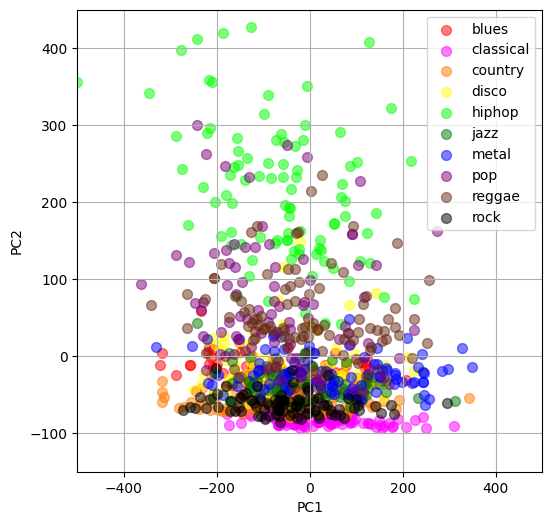

In [ ]:
# GTZANのみ
plt.figure(figsize=(6, 6))
plt.xlim((-500,500))
plt.ylim((-150,450))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)

plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

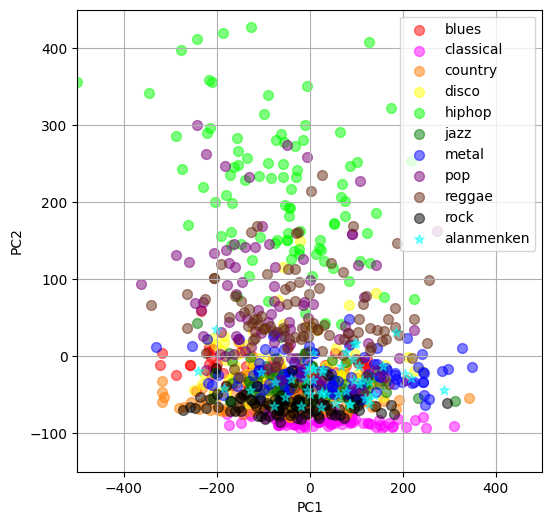

In [ ]:
# メンケン
plt.figure(figsize=(6, 6))
plt.xlim((-500,500))
plt.ylim((-150,450))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==10, 0], feature[num_label==10, 1], alpha=0.5,c="aqua",marker="*",label='alanmenken',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.show()

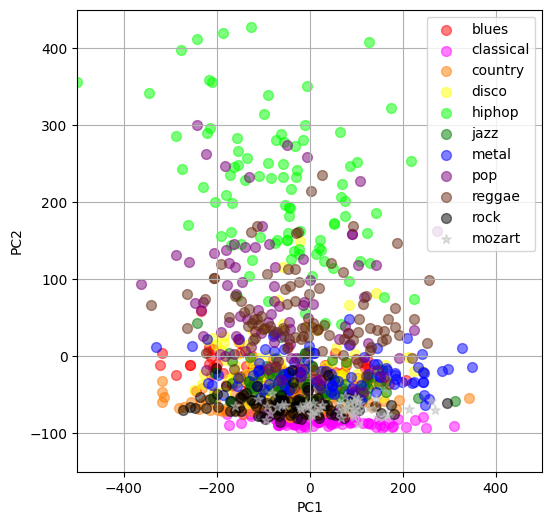

In [ ]:
# モーツァルト
plt.figure(figsize=(6, 6))
plt.xlim((-500,500))
plt.ylim((-150,450))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==11, 0], feature[num_label==11, 1], alpha=0.5,c="silver",marker="*",label='mozart',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.show()

##### **t-SNE**（perplexity=5）

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(1050,-1))

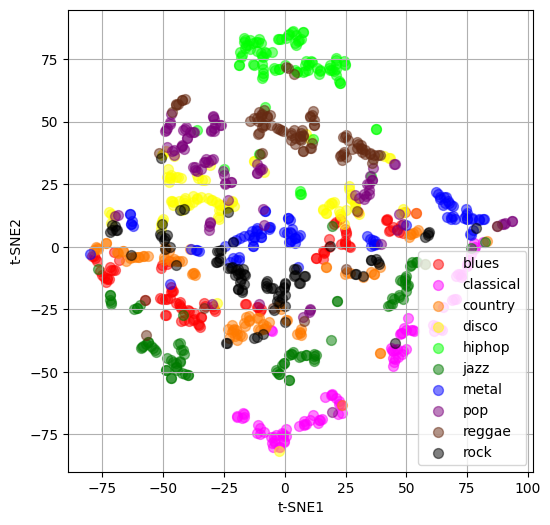

In [ ]:
# GTZANのみ
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

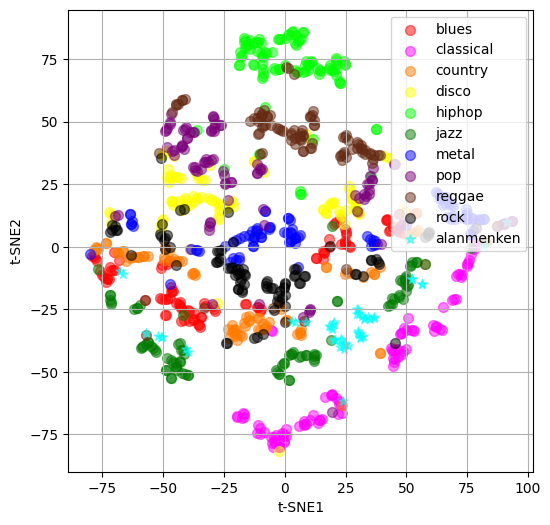

In [ ]:
# メンケン
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==10, 0], feature[num_label==10, 1], alpha=0.5,c="aqua",marker="*",label='alanmenken',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

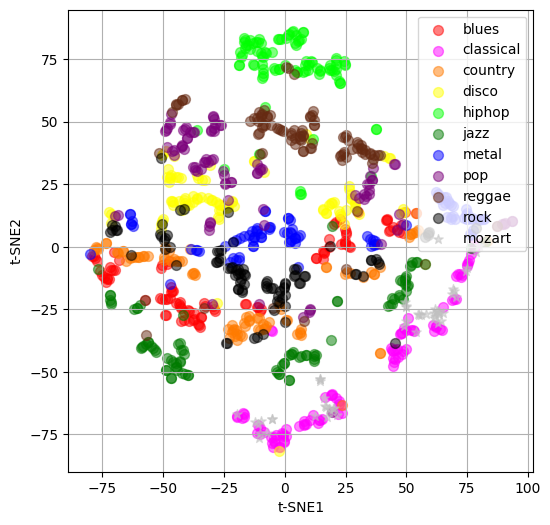

In [ ]:
# モーツァルト
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==11, 0], feature[num_label==11, 1], alpha=0.5,c="silver",marker="*",label='mozart',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

##### **t-SNE**（perplexity=?）

In [ ]:
tsne = TSNE(perplexity=20)
feature = tsne.fit_transform(output.reshape(1050,-1))

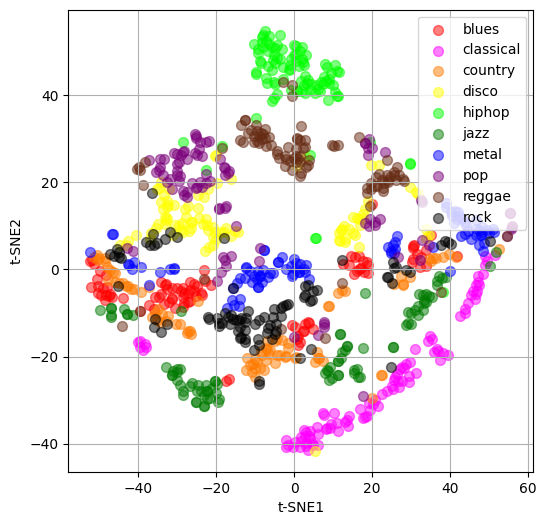

In [ ]:
# GTZANのみ
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

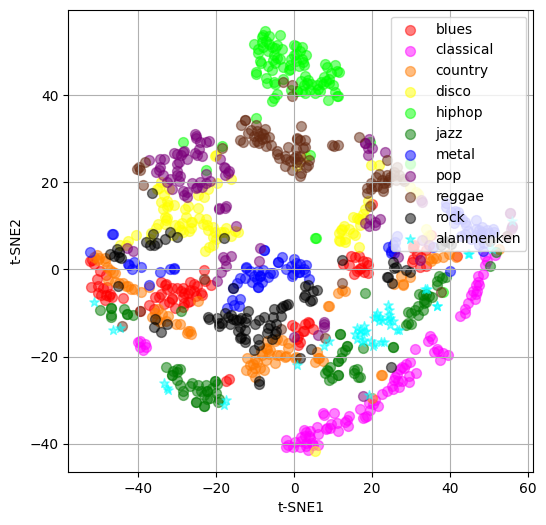

In [ ]:
#  メンケン
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==10, 0], feature[num_label==10, 1], alpha=0.5,c="aqua",marker="*",label='alanmenken',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

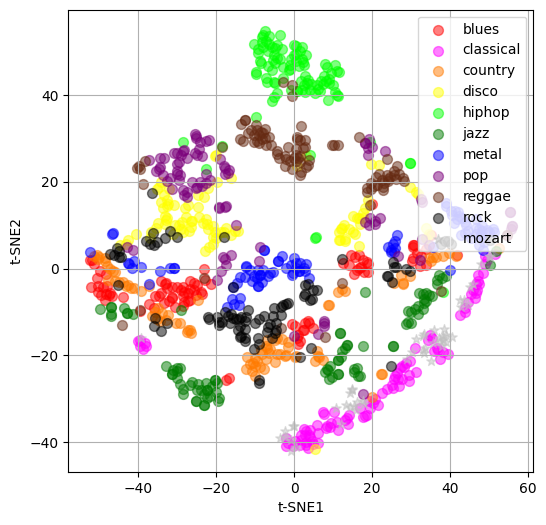

In [ ]:
# モーツァルト
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==11, 0], feature[num_label==11, 1], alpha=0.5,c="silver",marker="*",label='mozart',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()

##### **全部乗せ！**（t-sne）

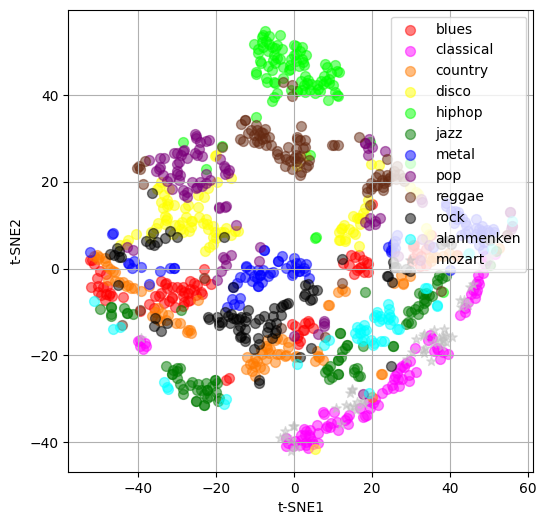

In [ ]:
# 全部
plt.figure(figsize=(6, 6))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.scatter(feature[num_label==10, 0], feature[num_label==10, 1], alpha=0.5,c="aqua",label='alanmenken',s=50)
plt.scatter(feature[num_label==11, 0], feature[num_label==11, 1], alpha=0.5,c="silver",marker="*",label='mozart',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')
plt.show()